<a href="https://colab.research.google.com/github/SandeshBashyal/naamii_labs_2023/blob/main/Lab_5_ans_active_learning_Assignment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Active Learning Lab: Margin of Confidence Method
__Content creator:__ [Pranav Poudel](https://www.linkedin.com/in/pranavpoudel/)

----
### Objective

The objective of the active learning lab is to enable students to implement the active learning method, specifically focusing on the margin of confidence technique. Through hands-on exercises and practical applications, students will learn to apply the margin of confidence method effectively

### Import important modules


In [1]:
import random
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils import data
import torchvision
import torchvision.transforms as transforms

from tqdm import tqdm

# from models import get_resnet18

### Function for Fixing Seeds


In [2]:
def set_seed(seed=None, seed_torch=True):
  if seed is None:
    seed = np.random.choice(2 ** 32)
  random.seed(seed)
  np.random.seed(seed)
  if seed_torch:
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.deterministic = True

  print(f'Random seed {seed} has been set.')

In [3]:
set_seed(2023)

Random seed 2023 has been set.


### Model:- ResNet18
ResNet is a deep convolutional neural network architecture that uses residual connections to address the problem of vanishing gradients. By enabling the direct flow of gradients through the network, ResNet allows for training very deep networks and has achieved state-of-the-art performance in computer vision tasks. Its residual blocks and skip connections have had a significant impact on advancing the performance of convolutional neural networks.
See the [original paper](https://arxiv.org/abs/1512.03385) for more details.

In [4]:
import torch.nn as nn
import torch
from torch import Tensor
from typing import Type


class BasicBlock(nn.Module):
    def __init__(
        self, 
        in_channels: int,
        out_channels: int,
        stride: int = 1,
        expansion: int = 1,
        downsample: nn.Module = None
    ) -> None:
        super(BasicBlock, self).__init__()
        # Multiplicative factor for the subsequent conv2d layer's output channels.
        # It is 1 for ResNet18 and ResNet34.
        self.expansion = expansion
        self.downsample = downsample
        self.conv1 = nn.Conv2d(
            in_channels, 
            out_channels, 
            kernel_size=3, 
            stride=stride, 
            padding=1,
            bias=False
        )
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv2d(
            out_channels, 
            out_channels*self.expansion, 
            kernel_size=3, 
            padding=1,
            bias=False
        )
        self.bn2 = nn.BatchNorm2d(out_channels*self.expansion)

    def forward(self, x: Tensor) -> Tensor:
        identity = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)

        if self.downsample is not None:
            identity = self.downsample(x)

        out += identity
        out = self.relu(out)
        return  out
    
class ResNet(nn.Module):
    def __init__(
        self, 
        img_channels: int,
        num_layers: int,
        block: Type[BasicBlock],
        num_classes: int  = 1000
    ) -> None:
        super(ResNet, self).__init__()
        if num_layers == 18:
            # The following `layers` list defines the number of `BasicBlock` 
            # to use to build the network and how many basic blocks to stack
            # together.
            layers = [2, 2, 2, 2]
            self.expansion = 1
        
        self.in_channels = 64
        # All ResNets (18 to 152) contain a Conv2d => BN => ReLU for the first
        # three layers. Here, kernel size is 7.
        self.conv1 = nn.Conv2d(
            in_channels=img_channels,
            out_channels=self.in_channels,
            kernel_size=7, 
            stride=2,
            padding=3,
            bias=False
        )
        self.bn1 = nn.BatchNorm2d(self.in_channels)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        self.layer1 = self._make_layer(block, 64, layers[0])
        self.layer2 = self._make_layer(block, 128, layers[1], stride=2)
        self.layer3 = self._make_layer(block, 256, layers[2], stride=2)
        self.layer4 = self._make_layer(block, 512, layers[3], stride=2)
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(512*self.expansion, num_classes)
    def _make_layer(
        self, 
        block: Type[BasicBlock],
        out_channels: int,
        blocks: int,
        stride: int = 1
    ) -> nn.Sequential:
        downsample = None
        if stride != 1:
            """
            This should pass from `layer2` to `layer4` or 
            when building ResNets50 and above. Section 3.3 of the paper
            Deep Residual Learning for Image Recognition
            (https://arxiv.org/pdf/1512.03385v1.pdf).
            """
            downsample = nn.Sequential(
                nn.Conv2d(
                    self.in_channels, 
                    out_channels*self.expansion,
                    kernel_size=1,
                    stride=stride,
                    bias=False 
                ),
                nn.BatchNorm2d(out_channels * self.expansion),
            )
        layers = []
        layers.append(
            block(
                self.in_channels, out_channels, stride, self.expansion, downsample
            )
        )
        self.in_channels = out_channels * self.expansion
        for i in range(1, blocks):
            layers.append(block(
                self.in_channels,
                out_channels,
                expansion=self.expansion
            ))
        return nn.Sequential(*layers)
    def forward(self, x: Tensor) -> Tensor:
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        # The spatial dimension of the final layer's feature 
        # map should be (7, 7) for all ResNets.
        feat = self.avgpool(x)
        x = torch.flatten(feat, 1)
        x = self.fc(x)
        return x, feat


def get_resnet18(in_channels, num_classes):
    """
    Args:
        in_channels:- channel of input image. 3 for RGB
        num_classes:- Number of classes to classify. 
    """
    return ResNet(img_channels=in_channels, num_layers=18, block=BasicBlock, num_classes=num_classes)

### Hyper-parameters

In [5]:
device = "cuda" if torch.cuda.is_available() else "cpu"

start_epoch = 0  
batch_size = 32
end_epoch = 5 
base_learning_rate = 0.0002
b1 = 0.5
b2 = 0.999

### Datasets and Transformations

In [6]:
# CIFAR10 normalizing
mean = (0.4914, 0.4822, 0.4465)
std = (0.2023, 0.1994, 0.2010)

# torchvision transforms
transform_train = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean, std),
])


transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean, std),
])

trainset = torchvision.datasets.CIFAR10(
    root='./CIFAR10', train=True, download=True,
    transform=transform_train)

testset = torchvision.datasets.CIFAR10(
    root='./CIFAR10', train=False, download=True,
    transform=transform_test)

Files already downloaded and verified
Files already downloaded and verified


### Training and Testing Loops

In [7]:
def train_one_epoch(model, dataloader, criterion, optimizer, epoch):
    model.train()
    with tqdm(dataloader, unit="batch") as tepoch:
        tepoch.set_description(f"Epoch: {epoch}")
        for img, label in tepoch:
            img, label = img.to(device), label.to(device)
            output, _ = model(img)
            loss = criterion(output, label)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            tepoch.set_postfix(Loss=loss.item())

In [8]:
def test(model, dataloader):
    print("Testing")
    correct = 0
    total = 0
    # since we're not training, we don't need to calculate the gradients for our outputs
    model.eval()
    with torch.no_grad():
        with tqdm(dataloader, unit="batch") as tepoch:
            tepoch.set_description("Testing: ")
            for images, labels in tepoch:
                images, labels = images.to(device), labels.to(device)
                # calculate outputs by running images through the network
                outputs, _ = model(images)
                # the class with the highest energy is what we choose as prediction
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

    print(f'Accuracy of the network on the 10000 test images: {100 * correct / total} %')
    return correct/total

In [9]:
# Dataloader
num_workers = 4

print(f'----> number of workers: {num_workers}')

# trainloader = torch.utils.data.DataLoader(
#     trainset, batch_size=batch_size, shuffle=True, num_workers=num_workers)
# testloader = torch.utils.data.DataLoader(
#     testset, batch_size=batch_size, shuffle=False, num_workers=num_workers)

----> number of workers: 4


### Active Learning Framework

1. Initialize data pool with labeled and unlabeled subsets.
2. Train a model on the labeled subset.
3. Iterate:
    - Use the model to predict on the unlabeled data.
    - Calculate uncertainty for each unlabeled sample.
    - Select the most uncertain samples.
    - Label selected samples.
    - Add labeled samples to the labeled subset.
    - Retrain the model.
4. Evaluate model performance.
5. Repeat steps 3-4 until a stopping criterion is met or budget is exhausted.
6. Train a final model using all labeled data.
7. Deploy the final model for inference.

In [10]:
#Active Learning Framework
train_indices = np.arange(len(trainset))
INITIAL_BUDGET = 10000
BUDGET = 5000
num_cycle = 3

initial_indices = random.sample(list(train_indices), INITIAL_BUDGET)
train_sampler = data.sampler.SubsetRandomSampler(initial_indices)

trainloader = torch.utils.data.DataLoader(trainset, sampler=train_sampler, 
        batch_size=batch_size, num_workers=num_workers)
testloader = torch.utils.data.DataLoader(
    testset, batch_size=batch_size, shuffle=False, num_workers=num_workers)
initial_unlabeled_indices = np.setdiff1d(list(train_indices), initial_indices)


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


In [11]:
#Model and Optimizer Setup
net = get_resnet18(in_channels=3, num_classes=10)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), lr=base_learning_rate, betas=(b1, b2))

In [12]:
net = net.to(device)
for i in range(start_epoch, end_epoch):
    train_one_epoch(net, trainloader, criterion, optimizer, i)    
    acc = test(net, testloader)
    torch.save(net.state_dict(), "initial_checkpoint.pt")

Epoch: 0: 100%|██████████| 313/313 [00:09<00:00, 33.10batch/s, Loss=1.98]


Testing


Testing: : 100%|██████████| 313/313 [00:04<00:00, 65.23batch/s]


Accuracy of the network on the 10000 test images: 42.92 %


Epoch: 1: 100%|██████████| 313/313 [00:09<00:00, 34.44batch/s, Loss=1.83]


Testing


Testing: : 100%|██████████| 313/313 [00:04<00:00, 70.22batch/s]


Accuracy of the network on the 10000 test images: 47.22 %


Epoch: 2: 100%|██████████| 313/313 [00:08<00:00, 36.78batch/s, Loss=1.28]


Testing


Testing: : 100%|██████████| 313/313 [00:04<00:00, 76.78batch/s]


Accuracy of the network on the 10000 test images: 52.41 %


Epoch: 3: 100%|██████████| 313/313 [00:08<00:00, 37.62batch/s, Loss=1.18]


Testing


Testing: : 100%|██████████| 313/313 [00:04<00:00, 74.15batch/s]


Accuracy of the network on the 10000 test images: 52.29 %


Epoch: 4: 100%|██████████| 313/313 [00:08<00:00, 36.65batch/s, Loss=1.49]


Testing


Testing: : 100%|██████████| 313/313 [00:04<00:00, 75.81batch/s]


Accuracy of the network on the 10000 test images: 54.61 %


In [13]:
#Random Sampling
import random
def random_sampler(unlabeled_indices):
    random.shuffle(unlabeled_indices)
    arg = np.random.randint(len(unlabeled_indices), size=len(unlabeled_indices))
    indices_to_label = unlabeled_indices[arg][:BUDGET]
    return indices_to_label

<h3>Task 1: Implement Margin of Confidence Method</h3>

Implement Margin of Confidence Method using following guideline in given loop below.

1. Calculate Probabilities
2. Get top two Probabilities
3. Calculate difference between top two probabilities
4. Calculate uncertainity = 1 - difference


In [14]:
import torch.nn.functional as F

def calculate_bvsb_uncertainty(model, data_loader, budget):
    model.eval()
    with torch.no_grad():
        unc_preds = []
        for images, _ in data_loader:
            outputs, _ = model(images.to(device))
            probabilities = F.softmax(outputs, dim=1)
            top2_probs, _ = torch.topk(probabilities, k=2, dim=1)
            differences = top2_probs[:, 0] - top2_probs[:, 1]
            uncertainity = 1 - differences
            unc_preds.extend(uncertainity.cpu())
        unc_preds = torch.stack(unc_preds)
    scores, query_indices = torch.topk(unc_preds, budget)
    return query_indices, scores

In [15]:
def bvsb_sampler(trainset, models, unlabeled_indices):
    unlabeled_dataloader = torch.utils.data.DataLoader(trainset, sampler=torch.utils.data.SequentialSampler(unlabeled_indices), batch_size=batch_size)
    arg, _ =  calculate_bvsb_uncertainty(models, unlabeled_dataloader, BUDGET)
    indices_to_label = list(torch.tensor(unlabeled_indices)[arg].numpy())
    return indices_to_label

### Random Sampling

In [16]:
indices_to_label = random_sampler(initial_unlabeled_indices)
current_indices = list(initial_indices) + list(indices_to_label)
sampler = data.sampler.SubsetRandomSampler(current_indices)
trainloader = torch.utils.data.DataLoader(trainset, sampler=sampler, 
        batch_size=batch_size, num_workers=num_workers)
unlabeled_indices = np.setdiff1d(list(train_indices), current_indices)

In [17]:
random_acc = []
for cycle in range(1,num_cycle):
    net = get_resnet18(in_channels=3, num_classes=10)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(net.parameters(), lr=base_learning_rate, betas=(b1, b2))
    net = net.to(device)
    best_acc = 0
    print(f"Cycle: {cycle}")
    for i in range(start_epoch, end_epoch):
        train_one_epoch(net, trainloader, criterion, optimizer, i)    
        acc = test(net, testloader)
        if acc > best_acc:
            best_acc = acc
    random_acc.append(best_acc)
    
    indices_to_label = random_sampler(unlabeled_indices)

    current_indices = list(current_indices) + list(indices_to_label)
    sampler = data.sampler.SubsetRandomSampler(current_indices)
    trainloader = torch.utils.data.DataLoader(trainset, sampler=sampler, 
        batch_size=batch_size, num_workers=num_workers)
    unlabeled_indices = np.setdiff1d(list(train_indices), current_indices)

Cycle: 1


Epoch: 0: 100%|██████████| 469/469 [00:12<00:00, 37.50batch/s, Loss=1.54]


Testing


Testing: : 100%|██████████| 313/313 [00:04<00:00, 75.31batch/s]


Accuracy of the network on the 10000 test images: 50.91 %


Epoch: 1: 100%|██████████| 469/469 [00:12<00:00, 37.57batch/s, Loss=1.24]


Testing


Testing: : 100%|██████████| 313/313 [00:04<00:00, 66.21batch/s]


Accuracy of the network on the 10000 test images: 53.77 %


Epoch: 2: 100%|██████████| 469/469 [00:12<00:00, 38.84batch/s, Loss=1.02]


Testing


Testing: : 100%|██████████| 313/313 [00:04<00:00, 68.58batch/s]


Accuracy of the network on the 10000 test images: 57.41 %


Epoch: 3: 100%|██████████| 469/469 [00:12<00:00, 36.97batch/s, Loss=0.956]


Testing


Testing: : 100%|██████████| 313/313 [00:04<00:00, 77.03batch/s]


Accuracy of the network on the 10000 test images: 58.92 %


Epoch: 4: 100%|██████████| 469/469 [00:12<00:00, 37.07batch/s, Loss=0.37]


Testing


Testing: : 100%|██████████| 313/313 [00:04<00:00, 66.12batch/s]


Accuracy of the network on the 10000 test images: 59.93 %
Cycle: 2


Epoch: 0: 100%|██████████| 625/625 [00:16<00:00, 37.67batch/s, Loss=1.35]


Testing


Testing: : 100%|██████████| 313/313 [00:04<00:00, 76.80batch/s]


Accuracy of the network on the 10000 test images: 50.85 %


Epoch: 1: 100%|██████████| 625/625 [00:16<00:00, 37.32batch/s, Loss=1.07]


Testing


Testing: : 100%|██████████| 313/313 [00:04<00:00, 63.83batch/s]


Accuracy of the network on the 10000 test images: 56.56 %


Epoch: 2: 100%|██████████| 625/625 [00:16<00:00, 37.42batch/s, Loss=1.15]


Testing


Testing: : 100%|██████████| 313/313 [00:04<00:00, 69.06batch/s]


Accuracy of the network on the 10000 test images: 60.95 %


Epoch: 3: 100%|██████████| 625/625 [00:16<00:00, 37.71batch/s, Loss=0.844]


Testing


Testing: : 100%|██████████| 313/313 [00:04<00:00, 77.53batch/s]


Accuracy of the network on the 10000 test images: 61.51 %


Epoch: 4: 100%|██████████| 625/625 [00:16<00:00, 37.59batch/s, Loss=1.23]


Testing


Testing: : 100%|██████████| 313/313 [00:04<00:00, 62.74batch/s]


Accuracy of the network on the 10000 test images: 63.54 %


### Uncertainity Based Sampling

In [18]:
#best vs second best sampler
net.load_state_dict(torch.load("initial_checkpoint.pt"))
indices_to_label = bvsb_sampler(trainset, net, initial_unlabeled_indices)


In [19]:
current_indices = list(initial_indices) + list(indices_to_label)
sampler = data.sampler.SubsetRandomSampler(current_indices)
trainloader = torch.utils.data.DataLoader(trainset, sampler=sampler, 
        batch_size=batch_size, num_workers=num_workers)
unlabeled_indices = np.setdiff1d(list(train_indices), current_indices)

In [20]:
bvsb_acc = []
for cycle in range(1,num_cycle):
    net = get_resnet18(in_channels=3, num_classes=10)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(net.parameters(), lr=base_learning_rate, betas=(b1, b2))
    net = net.to(device)
    best_acc = 0
    print(f"Cycle: {cycle}")
    for i in range(start_epoch, end_epoch):
        train_one_epoch(net, trainloader, criterion, optimizer, i)    
        acc = test(net, testloader)
        if acc > best_acc:
            best_acc = acc
            torch.save(net.state_dict(), f"bvsb_best{cycle}.pt")
    bvsb_acc.append(best_acc)

    net.load_state_dict(torch.load(f"bvsb_best{cycle}.pt"))
    indices_to_label = bvsb_sampler(trainset, net, unlabeled_indices)

    current_indices = list(current_indices) + list(indices_to_label)
    sampler = data.sampler.SubsetRandomSampler(current_indices)
    trainloader = torch.utils.data.DataLoader(trainset, sampler=sampler, 
        batch_size=batch_size, num_workers=num_workers)
    unlabeled_indices = np.setdiff1d(list(train_indices), current_indices)

Cycle: 1


Epoch: 0: 100%|██████████| 469/469 [00:12<00:00, 37.31batch/s, Loss=1.26]


Testing


Testing: : 100%|██████████| 313/313 [00:05<00:00, 60.62batch/s]


Accuracy of the network on the 10000 test images: 49.31 %


Epoch: 1: 100%|██████████| 469/469 [00:12<00:00, 37.05batch/s, Loss=1.08]


Testing


Testing: : 100%|██████████| 313/313 [00:04<00:00, 78.08batch/s]


Accuracy of the network on the 10000 test images: 53.43 %


Epoch: 2: 100%|██████████| 469/469 [00:12<00:00, 38.24batch/s, Loss=1.21]


Testing


Testing: : 100%|██████████| 313/313 [00:04<00:00, 77.39batch/s]


Accuracy of the network on the 10000 test images: 59.14 %


Epoch: 3: 100%|██████████| 469/469 [00:12<00:00, 37.75batch/s, Loss=1.11]


Testing


Testing: : 100%|██████████| 313/313 [00:05<00:00, 61.97batch/s]


Accuracy of the network on the 10000 test images: 60.61 %


Epoch: 4: 100%|██████████| 469/469 [00:12<00:00, 39.04batch/s, Loss=0.733]


Testing


Testing: : 100%|██████████| 313/313 [00:04<00:00, 73.36batch/s]


Accuracy of the network on the 10000 test images: 61.83 %
Cycle: 2


Epoch: 0: 100%|██████████| 625/625 [00:16<00:00, 38.31batch/s, Loss=1.01]


Testing


Testing: : 100%|██████████| 313/313 [00:04<00:00, 65.96batch/s]


Accuracy of the network on the 10000 test images: 50.66 %


Epoch: 1: 100%|██████████| 625/625 [00:15<00:00, 39.53batch/s, Loss=1.19]


Testing


Testing: : 100%|██████████| 313/313 [00:03<00:00, 80.47batch/s]


Accuracy of the network on the 10000 test images: 58.11 %


Epoch: 2: 100%|██████████| 625/625 [00:16<00:00, 36.92batch/s, Loss=0.918]


Testing


Testing: : 100%|██████████| 313/313 [00:03<00:00, 80.30batch/s]


Accuracy of the network on the 10000 test images: 61.37 %


Epoch: 3: 100%|██████████| 625/625 [00:16<00:00, 38.53batch/s, Loss=0.927]


Testing


Testing: : 100%|██████████| 313/313 [00:05<00:00, 61.85batch/s]


Accuracy of the network on the 10000 test images: 64.35 %


Epoch: 4: 100%|██████████| 625/625 [00:15<00:00, 39.46batch/s, Loss=0.553]


Testing


Testing: : 100%|██████████| 313/313 [00:03<00:00, 80.00batch/s]


Accuracy of the network on the 10000 test images: 66.32 %


In [21]:
active_learning_method = ["Random", "BvSB"]
accs = [random_acc, bvsb_acc]

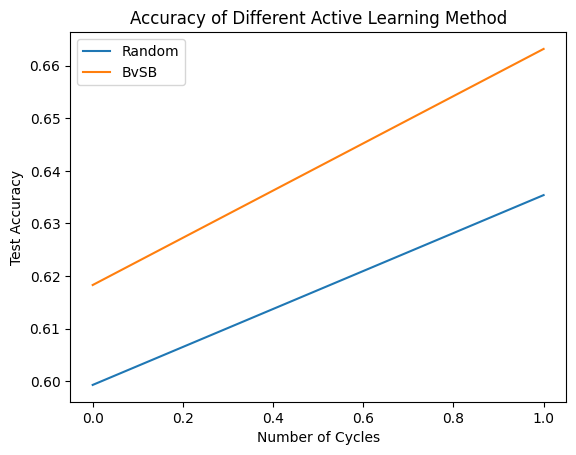

In [22]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots()
for i in range(len(active_learning_method)):
    # ax.plot(list(range(start_epoch, end_epoch)), train_dict["accs"], label=type)
    method_name = active_learning_method[i]
    method_acc = accs[i]
    no_trails = list(range(len(method_acc)))
    ax.plot(no_trails, method_acc, label=method_name)
ax.set_xlabel("Number of Cycles")
ax.set_ylabel("Test Accuracy")
ax.set_title("Accuracy of Different Active Learning Method")
ax.legend()
plt.show()
